*Before we get started, we will install the Uncertainty Engine, alongside some dependencies for this demo, to your local Google Colab. Please run the cell below (either by clicking the triangle or Shift+Enter) and proceed to the background.*

In [2]:
!pip install uncertainty-engine --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 54.5 MB/s eta 0:00:00



To access this cloud tool, your registered email is required.<br> **If you have not been registered speak to a member of the team for assistance.**

In [4]:
email = ""  # ENTER YOUR EMAIL HERE

# Bayesian Experimental Design of Bolometry System Lines of Sight

In this demo, we are aiming to design a diagnostic system for understanding the effective charge, $Z_{eff.}$, of a plasma in the tokamak ST-40.

## Background

The plasma's effective charge changes due to impurities present in the core plasma. The plasma's effective charge is known to affect the radiated emission from the plasma. This emission can be measured from bolometry systems.

*Forward models* can predict a diagnostic measurement from a certain plasma state. [INDICA](https://github.com/indica-mcf/Indica) contains such a model for bolometry systems.

Using INDICA, various amounts of Argon impurity were added to a flat top plasma equilibrium in the ST-40 tokamak. Examples of corresponding radiated emission cross sections and corresponding effective charge profiles are shown below.

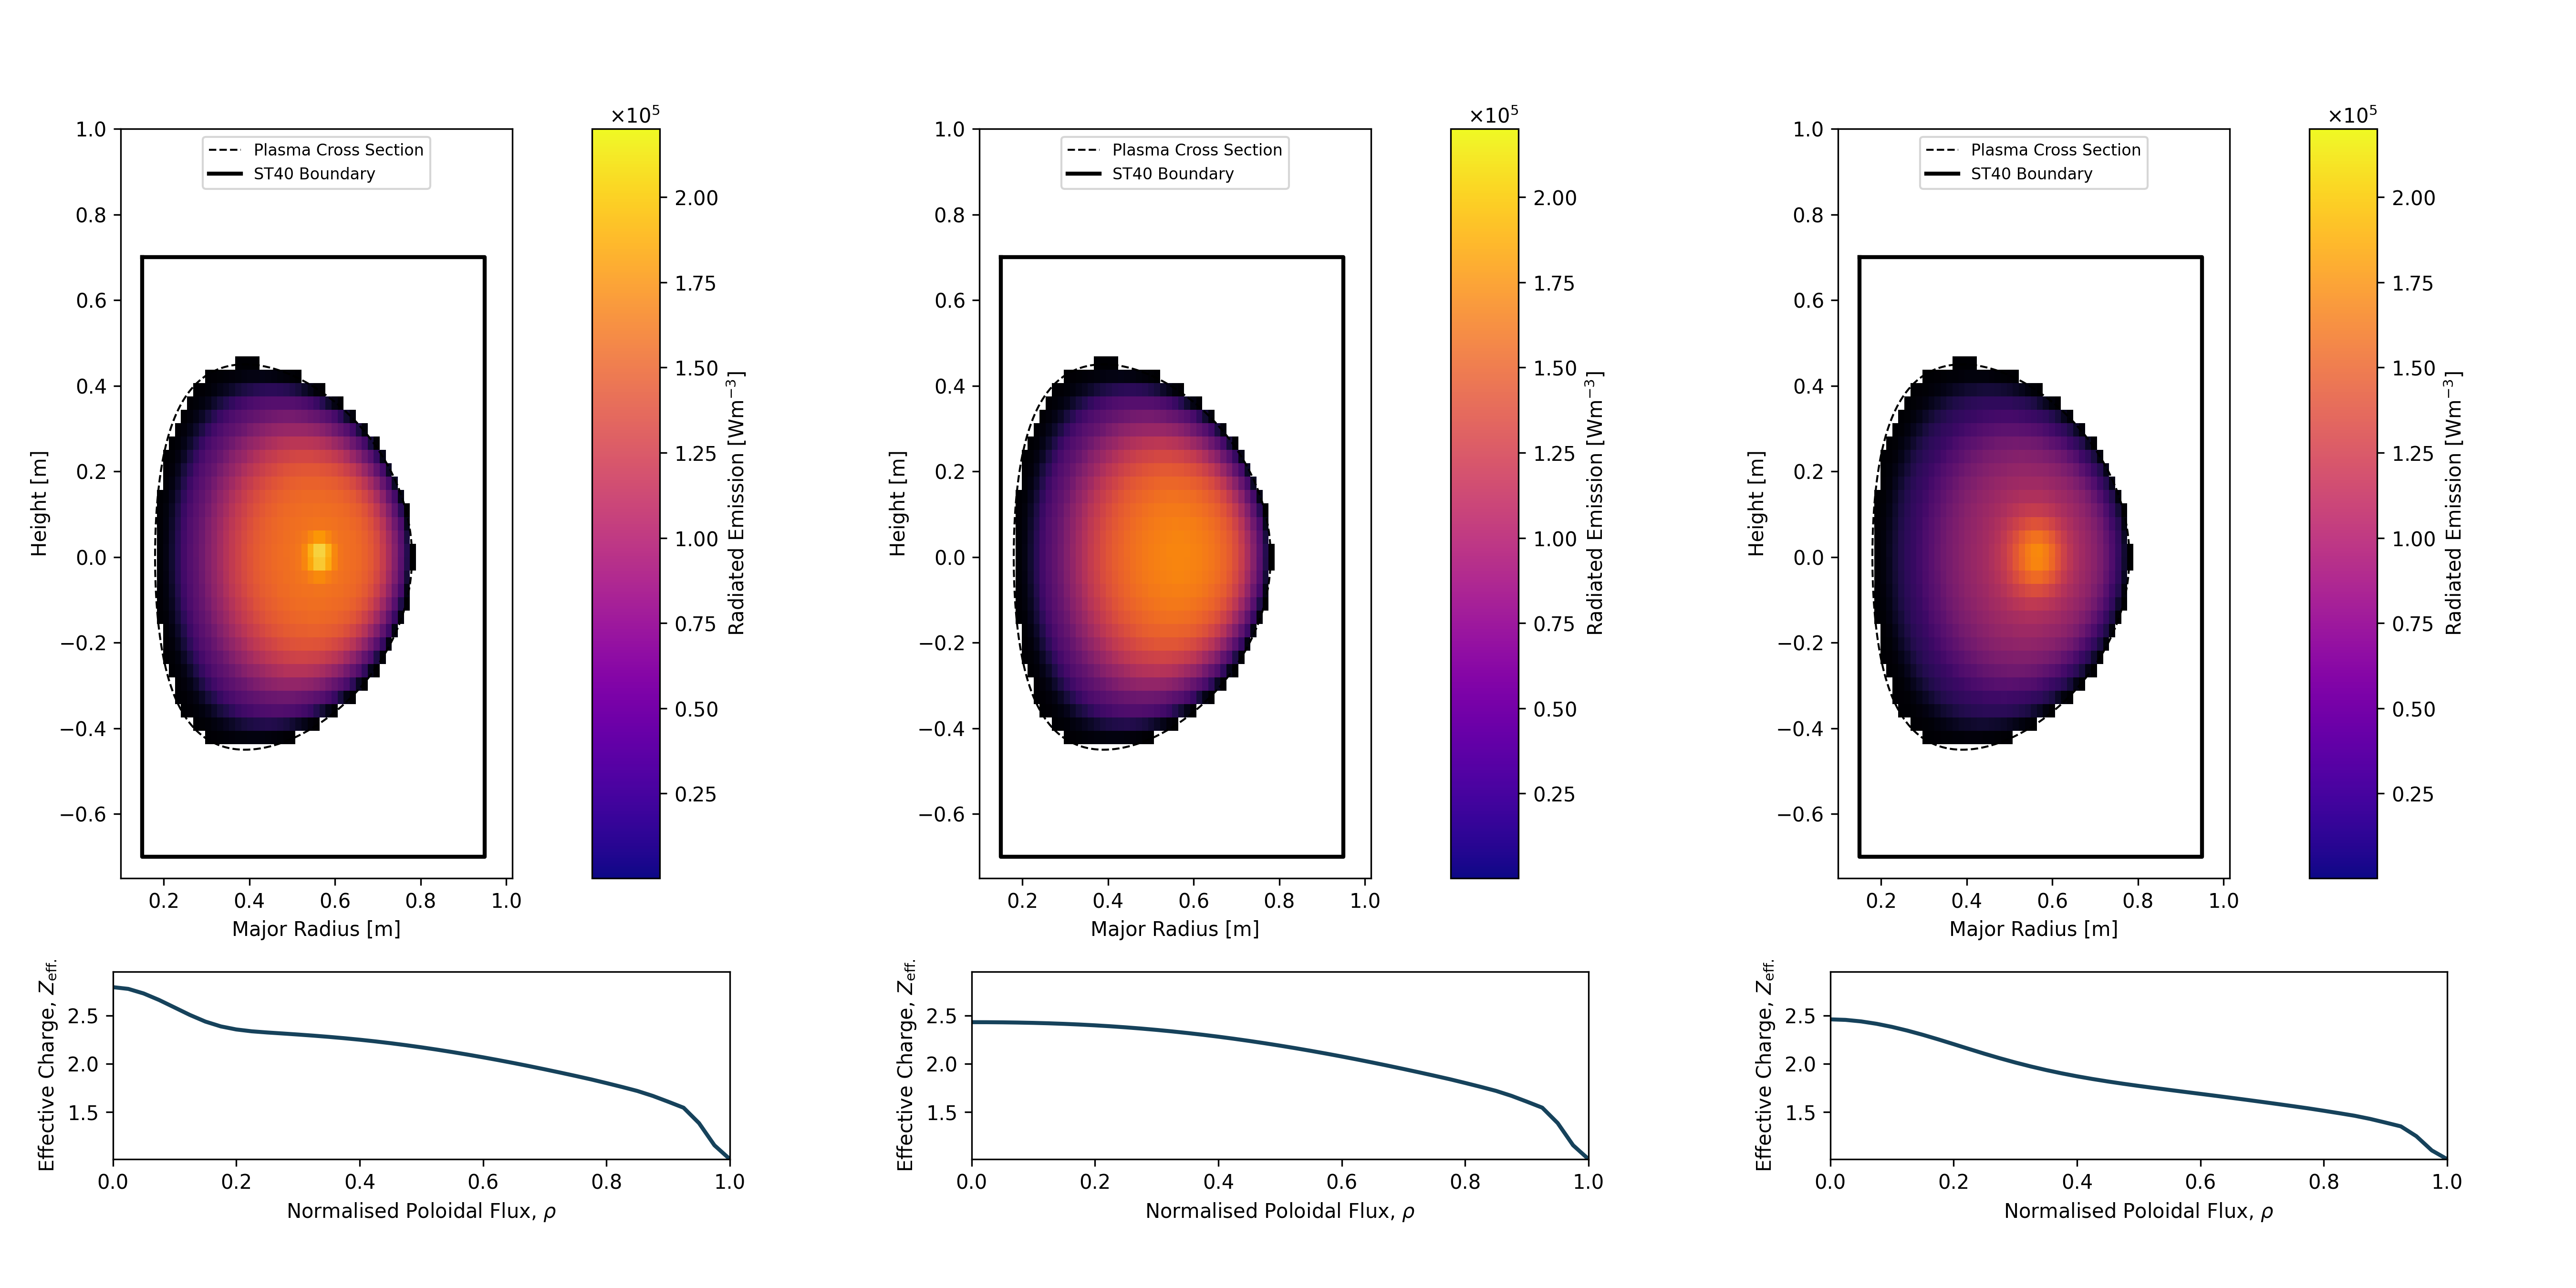

Bolometry systems can fan spectroscopic lines of sight (LoS) throughout the poloidal plane. Due to limited port space available for diagnostics, these lines of sight originate from a single location.

In this toy problem, we imagine the scenario where the port location is fixed and there is only the capacity to include three lines of sight from the twenty four options available.

We wish to identify the best three lines of sight from a fan of a bolometry system from the twenty four candidate lines of sight (left). We refer to each configuration of three lines of sight as a sensor set.

### Mission:
Can we identify the three *best* lines of sight to include in our bolometry system such that we give experimentalists the best prospect of measuring the plasma's effective charge in future experiments?

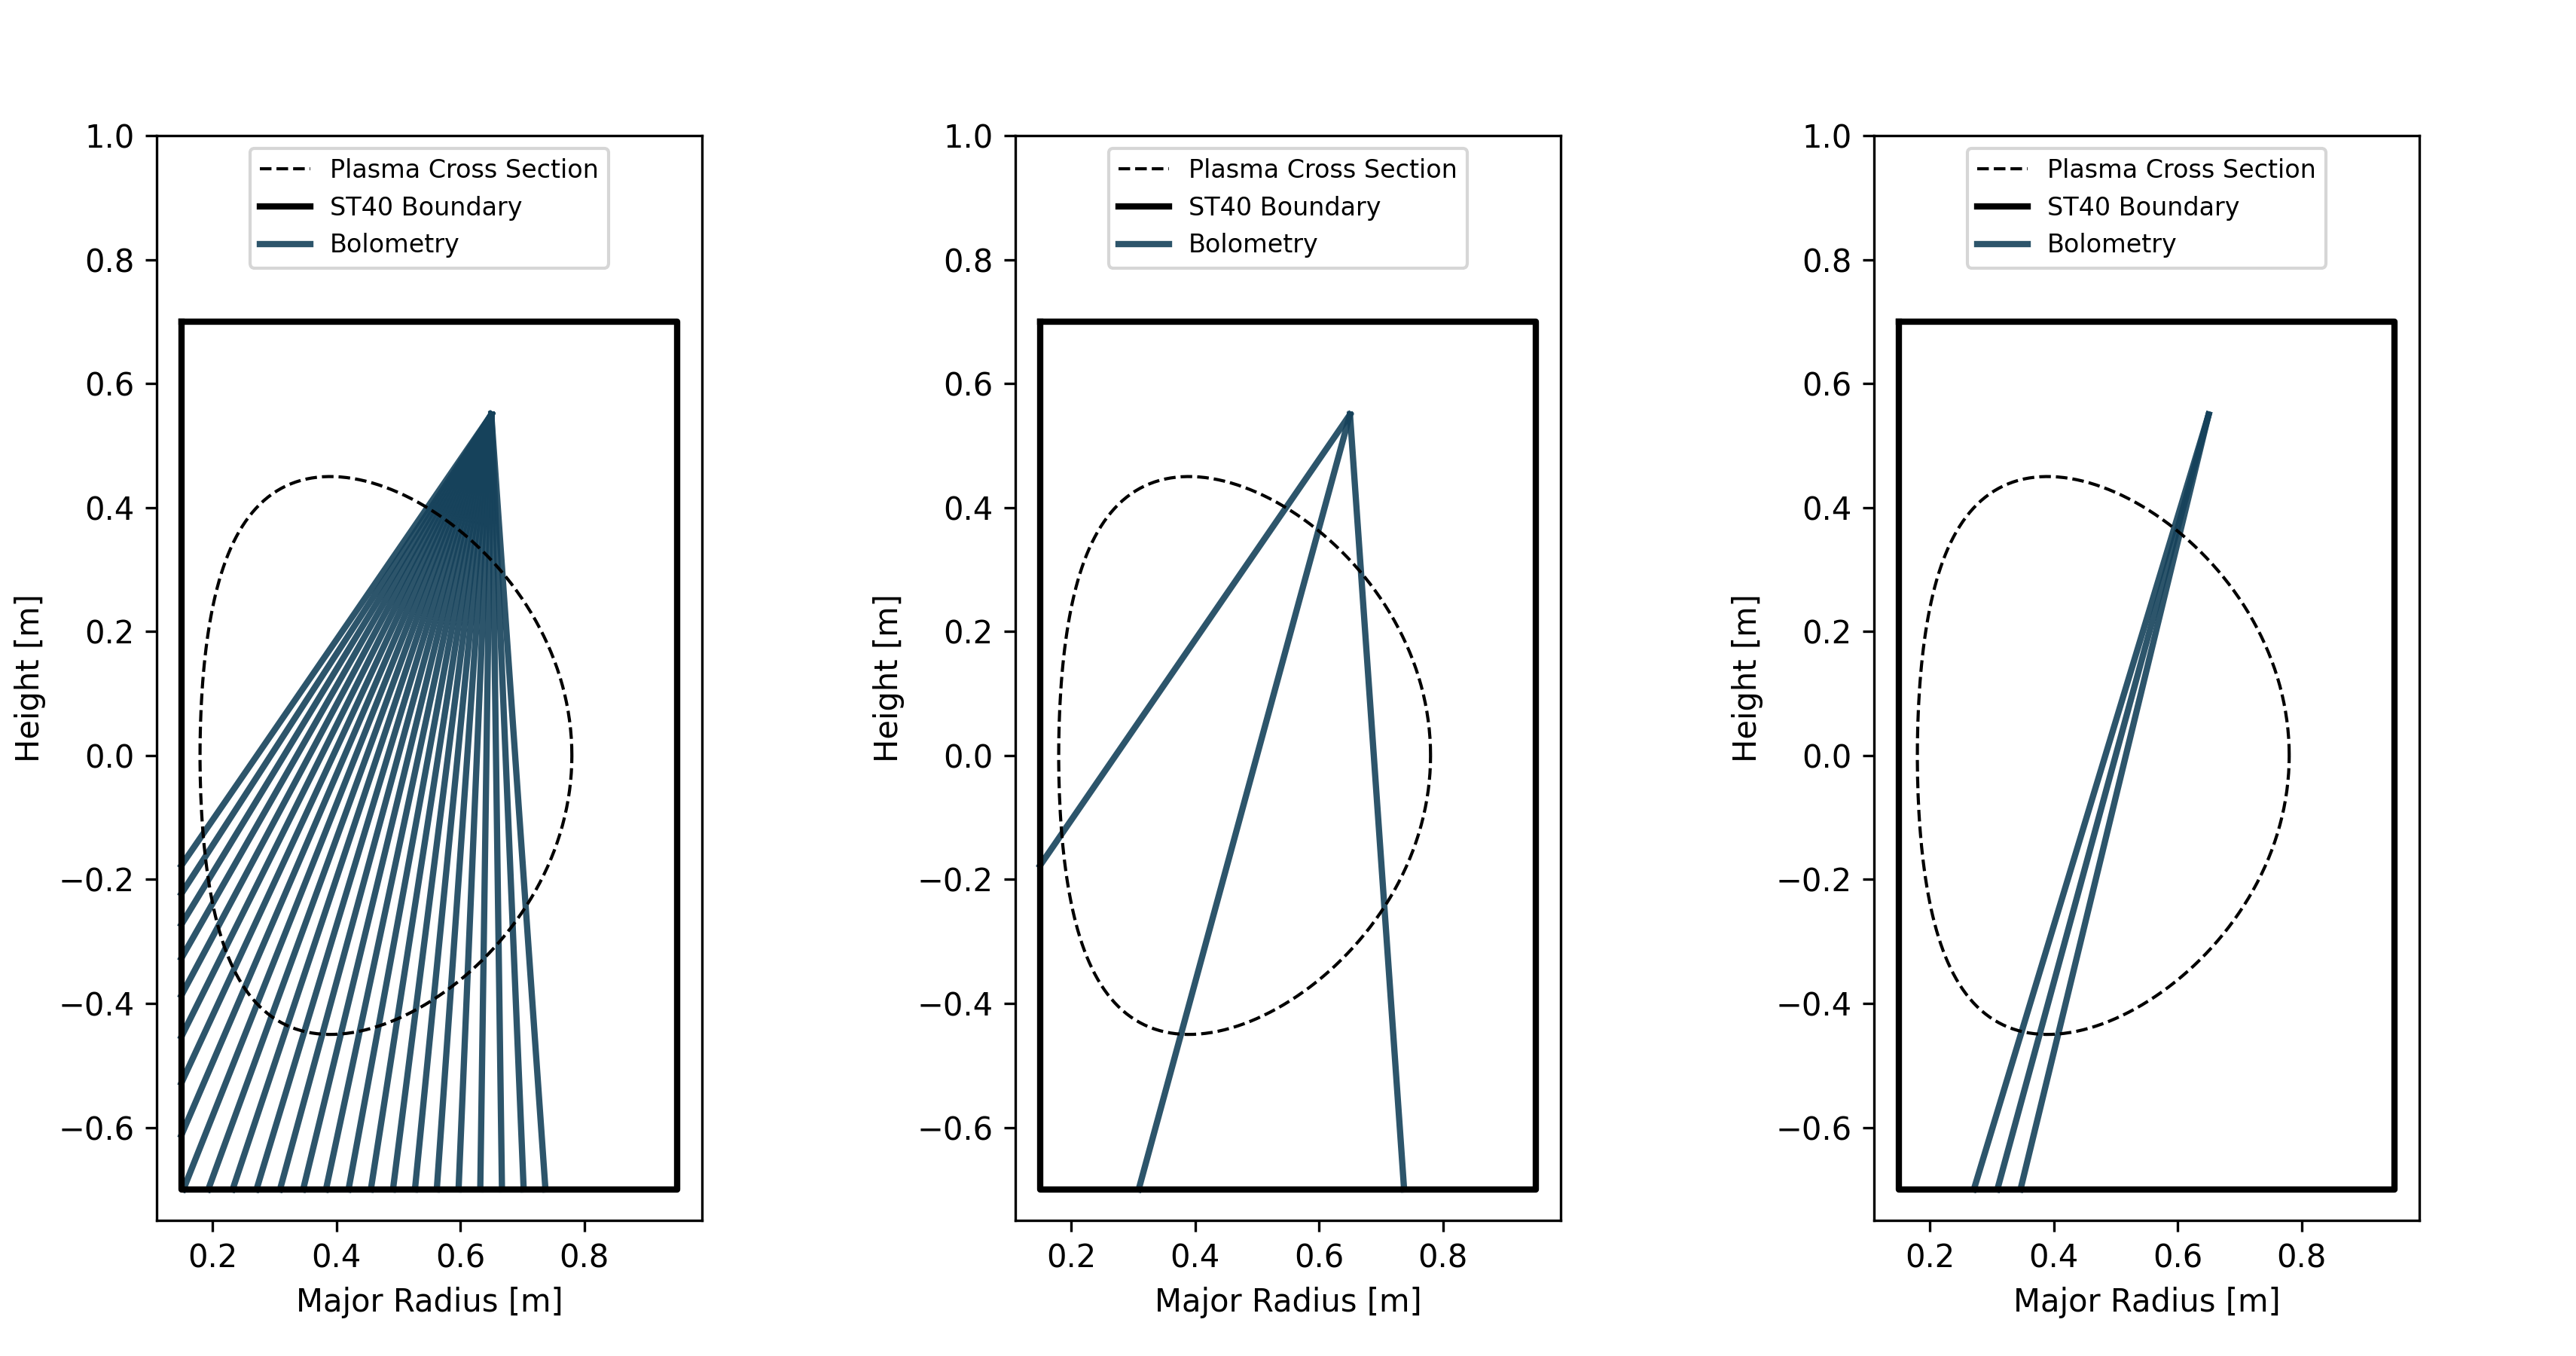

There are different definitions of the best sensor set.

In the world of Bayesian experimental design, the <strong><i>best</i></strong> sensor set is the one that maximises the <strong>E</strong>xpected <strong>I</strong>nformation <strong>G</strong>ain (EIG) from those sensors' measurements.

With our new framework, this can be achieved in 5 easy steps.
<ol>
    <li>Basic setup</li>
    <li>Define dataset and measurement uncertainty</li>
    <li>Setup the designer</li>
    <li>Suggest a sensor design</li>
    <li>Examine suggested designs</li>
</ol>

## 1. Basic setup

First, we need to download the relevant data for this demo.
<br>
We have hidden this code, but it can be seen by clicking 'Show code'.

In [11]:
#@title Click ▶️ to download the data for this notebook

# github repo link to data
repo = "https://raw.githubusercontent.com/digiLab-ai/STEPControl-Use-Cases/refs/heads/dan-live_demo/ImagingDemo/"

# First, we will download the data files required for this notebook (stored as csv)
!wget -q -O  Imaging_measurements_handsOn.csv {repo+"Data/Output/Imaging_measurements_handsOn.csv"}
!wget -q -O qoi.csv {repo+"Data/Output/qoi_z_eff.csv"}
!wget -q -O qoi_profile.csv {repo+"Data/Output/qoi_z_eff_profile.csv"}

# For visualisation, we will also download the raw states and the geometry
!wget -q -O Imaging_geometry_handsOn.csv {repo+"Data/Output/Imaging_geometry_handsOn.csv"}
!wget -O Imaging_states_handsOn.nc {repo+"Data/Output/Imaging_states_handsOn.nc"}

# Finally, we will download some helper functions for visualisation
!wget -q -O utils.py {repo+"notebooks/utils.py"}
!wget -q -O designer.py {repo+"notebooks/designer.py"}


--2025-02-28 01:22:16--  https://raw.githubusercontent.com/digiLab-ai/STEPControl-Use-Cases/refs/heads/dan-live_demo/ImagingDemo/Data/Output/Imaging_states_handsOn.nc
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17127859 (16M) [application/octet-stream]
Saving to: ‘Imaging_states_handsOn.nc’

Imaging_states_hand 100%[===================>]  16.33M  --.-KB/s    in 0.1s    

2025-02-28 01:22:17 (135 MB/s) - ‘Imaging_states_handsOn.nc’ saved [17127859/17127859]



Next, we will import and install all the packages we'll need.<br/>
Again, we have hidden this code, but it can be seen by clicking 'Show code'.

In [12]:
#@title Click ▶️ to import packages
import numpy as np
import pandas as pd
try:
    from google.colab import output
    # Enable interactive widgets
    output.enable_custom_widget_manager()
except:
    pass
import ipywidgets as widgets
from IPython.display import display

# designer and utils are downloaded from git in above cell
from designer import Designer

## 2. Define dataset and measurement uncertainty

This data-driven approach relies on samples of simulated sensor readings for each candidate sensor configuration. These samples are provided to the framework as a pandas DataFrame imported from a CSV file.

A sensor configuration may vary the physical attributes of the sensor, such as its location or angle, but it can also encompass variations in precision or entirely different types of sensors measuring distinct quantities.


### i. Sensor Measurements
For this demonstration, each candidate sensor configuration corresponds to a unique line of sight. In the DataFrame, each row represents simulated readings at a specific time, while each column corresponds to a simulated sensor.

In [14]:
sensor_df = pd.read_csv("Imaging_measurements_handsOn.csv")
sensor_df

,LoS_0,LoS_1,LoS_2,LoS_3,LoS_4,LoS_5,LoS_6,LoS_7,LoS_8,LoS_9,...,LoS_15,LoS_16,LoS_17,LoS_18,LoS_19,LoS_20,LoS_21,LoS_22,LoS_23,LoS_24
0,55451.026997,60942.698412,66538.706181,72259.935043,77992.825761,83581.115766,88907.895374,93847.658305,98312.862902,102136.887618,...,111085.740453,109298.315823,105631.450240,100720.344889,95454.383183,89923.943001,83788.050124,76719.248248,68617.275034,59289.708018
1,29391.847430,32213.431469,35081.359283,38013.740368,40964.907566,43865.671920,46676.971982,49357.192678,51903.638988,54254.323880,...,61391.377427,60380.562571,58449.892923,55665.258494,52286.924391,48532.397753,44558.357730,40393.021640,35981.936472,31128.664402
2,52497.601571,57684.751276,62968.441230,68368.542432,73778.211525,79049.641956,84072.463031,88728.056538,92932.986641,96520.832101,...,103062.116544,101352.048496,98103.374053,93999.013289,89711.693235,84859.248672,79168.053938,72521.004251,64883.434519,56085.919371
3,45454.499112,50130.712208,54973.397627,60022.427237,65213.519457,70439.289946,75627.345364,80687.884983,85569.448304,90111.348719,...,102532.382880,100823.410160,97791.520411,93438.356689,87966.488329,81536.692721,74336.306592,66544.680770,58291.368983,49496.807629
4,38446.501455,42317.180170,46315.518060,50485.728122,54788.806125,59159.699568,63577.475447,68015.396370,72492.433077,76933.250936,...,94629.236844,93252.868452,89902.114589,84722.487095,78245.435147,71030.881593,63589.689540,56214.360939,48960.155325,41579.160112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998,28824.941571,31572.519370,34355.564825,37187.287734,40017.453430,42772.177739,45406.900492,47879.035410,50194.169450,52320.841151,...,61264.551370,60379.979103,58057.810024,54599.385496,50654.172499,46714.151945,42919.023372,39094.890086,35015.618329,30419.280996
999,46436.377672,50998.566611,55641.311921,60382.384213,65128.677684,69749.919988,74149.640467,78223.471572,81901.009366,85036.829421,...,92959.643517,91642.598314,88019.884499,83408.552305,79117.458508,74728.568868,69730.168157,63908.503862,57220.982932,49510.884953
1000,33828.761267,37100.713597,40427.792910,43829.534295,47251.317012,50614.706188,53879.516535,57009.879662,60024.708822,62893.141580,...,74876.457628,73783.956238,71030.241414,66863.216365,61920.562070,56763.930883,51701.555450,46693.271102,41538.745199,35908.531635
1001,27556.247780,30171.744199,32818.002832,35506.260873,38186.226816,40782.197616,43240.927512,45502.833788,47538.391366,49266.246404,...,56455.004001,55876.793330,52973.306182,49148.735890,45917.444716,43172.112237,40332.848624,37081.837094,33353.141617,29030.288704


We must also define the expected uncertainty of our sensor measurements. This can include instrumental uncertainties and uncertainties in the forward model used to predict the measurements.<br>Here, we will use 5% of the median measurement. When optimising real-world sensors, consult each candidate sensor's datasheet for its precision or uncertainty.

In [15]:
sigma = float(0.05 * np.median(sensor_df.values))
sigma

3237.1571071277476

### ii. Quantity of Interest

In this demo, we will define quantities of interest (QOIs) to be the effective charge throughout the plasma $Z_{\mathrm{eff.}}$. <br>
This is a radial profile and so, for simplicity, we will also condense the information with the average effective charge, $\langle Z_{\mathrm{eff.}}\rangle$, and the maximum effective charge, $Z_{\mathrm{eff., max}}$.

In [16]:
qoi_df = pd.read_csv("qoi.csv")
qoi_df

,Z_eff_max,Z_eff_ave
0,2.486190,1.935552
1,2.922230,2.402350
2,2.298717,1.944746
3,2.000748,1.623339
4,2.715367,2.016006
...,...,...
998,2.137163,1.719412
999,2.915605,2.246450
1000,2.457835,2.064830
1001,2.477908,2.103732


In [17]:
qoi_profile_df = pd.read_csv("qoi_profile.csv")
qoi_profile_df

,ρ=0.000,ρ=0.025,ρ=0.050,ρ=0.075,ρ=0.100,ρ=0.125,ρ=0.150,ρ=0.175,ρ=0.200,ρ=0.225,...,ρ=0.775,ρ=0.800,ρ=0.825,ρ=0.850,ρ=0.875,ρ=0.900,ρ=0.925,ρ=0.950,ρ=0.975,ρ=1.000
0,2.486190,2.483712,2.476458,2.464703,2.448721,2.428789,2.405186,2.378209,2.348331,2.316130,...,1.618724,1.589136,1.559027,1.527845,1.490024,1.445820,1.400217,1.283769,1.115711,1.011199
1,2.922230,2.921151,2.917889,2.912413,2.904690,2.894687,2.882373,2.867729,2.850819,2.831760,...,2.051848,2.002488,1.951789,1.898842,1.834191,1.758301,1.679565,1.479676,1.191901,1.011304
2,2.298717,2.297714,2.294749,2.289892,2.283212,2.274780,2.264667,2.252952,2.239778,2.225334,...,1.717257,1.684210,1.650160,1.614511,1.570826,1.519453,1.466194,1.329933,1.133247,1.010469
3,2.000748,1.997484,1.988265,1.973952,1.955407,1.933494,1.909077,1.883022,1.856178,1.829387,...,1.445693,1.425416,1.404526,1.382676,1.355890,1.324396,1.291882,1.207726,1.085751,1.010447
4,2.715367,2.709651,2.693391,2.667918,2.634566,2.594673,2.549578,2.500640,2.449356,2.397313,...,1.692556,1.660724,1.627912,1.593546,1.551414,1.501854,1.450477,1.318915,1.128956,1.010449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998,2.137163,2.135523,2.130689,2.122794,2.111972,2.098356,2.082083,2.063301,2.042277,2.019348,...,1.466152,1.443221,1.420106,1.396413,1.367975,1.334947,1.301134,1.214667,1.089740,1.012731
999,2.915605,2.911980,2.901509,2.884792,2.862433,2.835039,2.803218,2.767599,2.729012,2.688404,...,1.882839,1.841940,1.799830,1.755749,1.701757,1.638268,1.572368,1.404366,1.162172,1.010475
1000,2.457835,2.457088,2.454814,2.450970,2.445509,2.438387,2.429560,2.418991,2.406704,2.392757,...,1.795693,1.758206,1.719793,1.679789,1.631058,1.573941,1.514842,1.364379,1.147512,1.012011
1001,2.477908,2.476896,2.473929,2.469115,2.462560,2.454372,2.444658,2.433531,2.421137,2.407645,...,1.857385,1.817931,1.777211,1.734514,1.682143,1.620514,1.556531,1.393269,1.157847,1.010447


In step 3, we will use our designer to help visualise these data sets in a more intuitive fashion.

## 3. Setup the designer

We will provide the designer with our dataset of observable quantities, the expected uncertainty on these observable quantities.

In [18]:
designer = Designer(email=email, observables=sensor_df, sigma=sigma, quantities_of_interest=qoi_df)

### iv. Visualising the data

We have added some plotting functionality to allow this data to be visualised.

On the left hand side, we have the emission distributions for the different plasma states and the corresponding average and maximum effective charge are displayed.

On the right hand side, we have the corresponding XRCS measurements for the possible lines of sight (as modelled by INDICA).

Please use the slider along the top to visualize the different plasma states in our dataset.

In [19]:
designer.visualise_data()

Output()

### v. Beat the designer!

Before we make our suggestion for the optimal sensor set, we challenge you to beat our designer! Which three sensors would you choose?

Use the plotting visualisation to decide your choice of sensors. Can your chosen sensors differentiate between the different plasma states?

In [20]:
designer.select_design()

Output()

Your chosen design is shown in the cell below. To change the design, use the interactive plot above to select new lines of sight.

In [ ]:
designer.chosen_design

AttributeError: 'Designer' object has no attribute 'plotter'

## 4. Get suggested sensor designs

Define the number of sensors you wish to place and how many different sensor sets you wish to evaluate. Using a genetic algorithm, sensor sets are intelligently selected for evaluation.

The top 5 of the evaluated sensor sets is returned for examination.

Let's suggest some 3-sensor sets after evaluating 100 different sets.<br/><br/>
(This should take approximately 4 minutes, in the meantime you can think more about which sensors you would choose.)

In [ ]:
designer.suggest(num_sensors=3, num_eval=100)

Let's visualise the suggested sensors!

In [ ]:
designer.visualise_data(selected_lines=designer.best_design)

In [ ]:
designer.visualise_data(selected_lines=designer.worst_design)

### ii.  What are the cominalities between the suggested good sensor designs?

Let's <strong>visualise the distribution of Expected Information Gain (EIG) scores</strong> of the evaluated sensor sets, providing valuable insights for decision-making:

<ol>
    <li><strong>Cluster Identification:</strong> Identify clusters of high-performing sets for further examination</li>
    <li><strong>Distribution Width:</strong> A narrow distribution suggests flexibility, while a broad one signals the need for careful placement.</li>
    <li><strong>Decision Confidence:</strong> Gain confidence in the robustness of a chosen sensor set based on its position relative to other evaluated sets.</li>
</ol>

In [ ]:
designer.visualise_score_distribution()

In the above histogram, hover over the different bars to see the EIG scores of different sensor designs.<br>
How did your suggested design do? <br>

In [ ]:
designer.score_design(designer.chosen_design)

AttributeError: 'Designer' object has no attribute 'score_design'


Which designs have worst performance and which have greatest? Use the plotter below to investigate.

In [ ]:
designer.select_design()

### iii. How does the EIG relate to uncertainty in the $Z_{\mathrm{eff.}}$ profile of our various measurements?

We can use the designer to see, for a certain design choice, the expected uncertainty for our $Z_{\mathrm{eff.}}$ profile for different measurements. This uncertainty relates to the *posterior* probability of different $Z_{\mathrm{eff.}}$ values given a measurement from our chosen sensor set (design choice).<br>

Below, we will plot this posterior probability for the various measurements in our dataframe.<br>

For ease, we have calculated the average reelative uncertainty for each design choice. This is the standard deviation of the posterior distribution divided by the mean of the posterior distribution averaged across the whole profile and all measurements.

Due to the limited time in this demo, we have not performed an exhaustive search of all design choices. There is no guarantee that our *best* design corresponds to the lowest average relative uncertainty.<br>
However, let's see how it performed!

The suggested best design:

In [ ]:
designer.visualise_posterior(designer.best_design)

Your proposed design:

In [ ]:
designer.visualise_posterior(designer.chosen_design)

Worst performing design:

In [ ]:
designer.visualise_posterior(designer.worst_design)

## 5. Extension: Redundancy Analysis

We found that several sensor sets performed similarly well.
Due to the limited number of sensors, there is no space for redundant sensors. However, what happens if sensors could get damaged? How tolerant are our suggested sensor sets to failure of one of the sensors?

This can be investigated through <strong>redundancy analysis</strong> on the suggested designs. This helps:

<ol>
    <li><strong>Resilience Assessment:</strong> Determine how resilient a sensor set is to failure. If performance drops significantly when a sensor is removed, the system is less robust.</li>
    <li><strong>Failure Tolerance:</strong> Allows you to assess which set can better tolerate individual sensor failures.</li>
    <li><strong>Critical Sensor Identification:</strong> Identify the most critical sensors, helping prioritize maintenance or redundancy planning.</li>
</ol>

Below, we will perform redundancy analysis for our suggested sensor set.

In [ ]:
designer.redundancy_analysis(designer.best_design, num_iter=2)